Loaded maze data: 10x10 maze with 100 nodes
Parsed path: 49 nodes, 49 directions
Start node: 19, End node: 51
Visualization saved to: generated_path_visualization.png


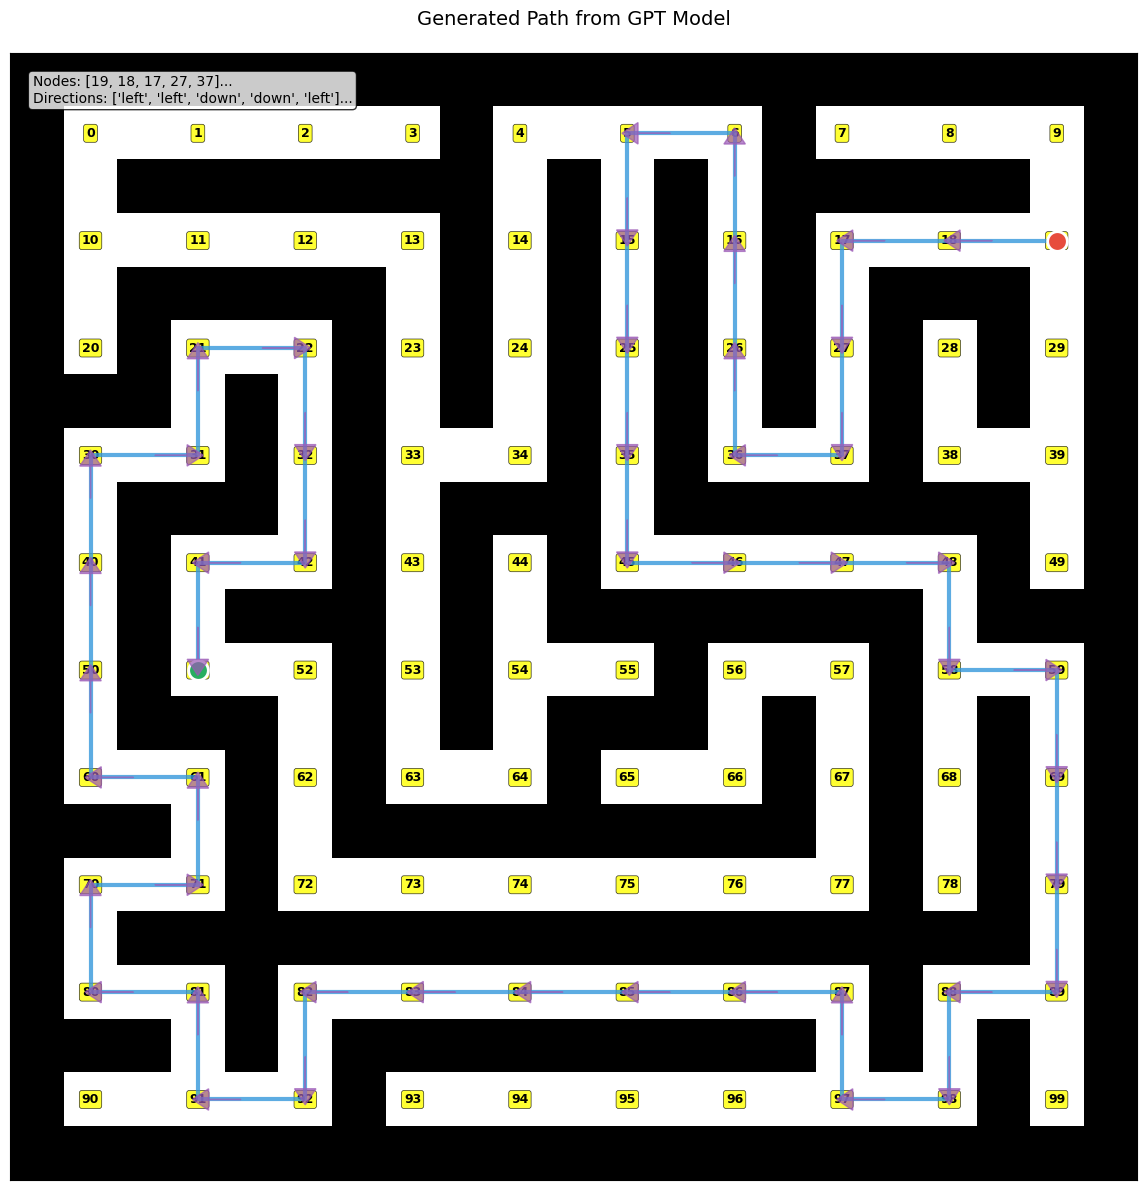

In [1]:
# Add the path visualizer function
import sys
sys.path.append('.')  # Add current directory to path

from path_visualizer import PathVisualizer, visualize_generated_path

# Test the path visualizer with the generated path
example_path = "19 28 19 left 18 left 17 down 27 down 37 left 36 up 26 up 16 up 6 left 5 down 15 down 25 down 35 down 45 right 46 right 47 right 48 down 58 right 59 down 69 down 79 down 89 left 88 down 98 left 97 up 87 left 86 left 85 left 84 left 83 left 82 down 92 left 91 up 81 left 80 up 70 right 71 up 61 left 60 up 50 up 40 up 30 right 31 up 21 right 22 down 32 down 42 left 41 down 51 right"

# Create visualizer
visualizer = PathVisualizer()

# Visualize the path (this will automatically skip the first 2 tokens as specified)
fig = visualizer.visualize_path(
    example_path,
    title="Generated Path from GPT Model",
    save_path="generated_path_visualization.png"
)

In [2]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "0 5 0" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------
# Configuration for training GPT on maze navigation data
# Optimized for path learning task

# I/O
out_dir = 'out-maze-nav'
eval_interval = 250
log_interval = 10
eval_iters = 100
eval_only = False
always_save_checkpoint = True

# wandb logging
wandb_log = False
wandb_project = 'maze-nav'
wandb_run_name = 'maze-nav-gpt'

# data
dataset = 'maze/maze_nav_data'  # This should match your maze data directory
gradient_accumulation_steps = 1  # Reduced for smaller sequences
batch_size = 32  # Reasonable batch size for path learning
max_seq_len = 512  # Maximum sequence length for any path (no artificial limit)

# model - smaller model suitable for maze navigation
n_layer = 6   # Fewer layers for simpler task
n_head = 6    # Fewer attention heads
n_embd = 192  # Smaller embedding dimension
dropout = 0.1 # Some dropout for regularization
bias = False  # Cleaner model

# adamw optimizer
learning_rate = 3e-4  # Slightly higher learning rate
max_iters = 5000      # Fewer iterations needed
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0

# learning rate decay settings
decay_lr = True
warmup_iters = 100    # Quick warmup
lr_decay_iters = 5000 # Match max_iters
min_lr = 3e-5

# DDP settings
backend = 'nccl'

# system
device = 'cuda'
# Note: dtype check is done in train.py
dtype = 'bfloat16'  # will be validated in train.py
compile = False 


# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # Handle both string and integer tokens for maze navigation
    stoi, itos = meta['stoi'], meta['itos']
    
    def encode(s):
        if isinstance(s, str):
            if s.isdigit():
                # Handle numeric node IDs
                return [stoi[s]] if s in stoi else [int(s)]
            else:
                # Handle direction tokens or other strings
                tokens = s.split()
                return [stoi[token] if token in stoi else int(token) if token.isdigit() else stoi.get(token, 0) for token in tokens]
        elif isinstance(s, list):
            # Handle list of tokens
            return [stoi[str(token)] if str(token) in stoi else (int(token) if isinstance(token, str) and token.isdigit() else token) for token in s]
        else:
            return [stoi[str(s)] if str(s) in stoi else s]
    
    def decode(l):
        if 'direction_tokens' in meta:
            # Maze navigation specific decoding
            result = []
            for i in l:
                token = itos.get(i, str(i))
                result.append(token)
            return ' '.join(result)
        else:
            # Standard string concatenation
            return ''.join([itos.get(i, str(i)) for i in l])
else:
    # # ok let's assume gpt-2 encodings by default
    # print("No meta.pkl found, assuming GPT-2 encodings...")
    # enc = tiktoken.get_encoding("gpt2")
    # encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    # decode = lambda l: enc.decode(l)
    raise ValueError("No meta.pkl found")

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()

print(f"Starting with: {start}")
start_ids = encode(start)
print(f"Encoded as: {start_ids}")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            generated_sequence = y[0].tolist()
            decoded_output = decode(generated_sequence)
            print(f"Sample {k+1}:")
            print(f"Raw tokens: {generated_sequence}")
            print(f"Decoded: {decoded_output}")
            print('---------------')


number of parameters: 1.16M
Loading meta from data/maze/maze_nav_data/meta.pkl...
Starting with: 0 5 0
Encoded as: [0, 5, 0]


/home/xh/projects/grid-in-llm/model.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, device=self.device)


Sample 1:
Raw tokens: [0, 5, 0, 102, 10, 101, 11, 101, 12, 101, 13, 102, 23, 102, 33, 101, 34, 100, 24, 100, 14, 100, 4, 101, 5]
Decoded: 0 5 0 down 10 right 11 right 12 right 13 down 23 down 33 right 34 up 24 up 14 up 4 right 5
---------------


In [3]:
# To use the logit lens we have to define tokenizer
import numpy as np

class MazeNavTokenizer:
    def __init__(self, encode, decode):
        self._encode_fn = encode
        self._decode_fn = decode

    def encode(self, x):
        return torch.tensor(self._encode_fn(x))

    def __call__(self, x, **kwargs):
        "Return the token ids in ecco style"
        return self.encode(x)

    def decode(self, x):
        """Decode tokens - handles both single tokens and lists"""
        # Handle different input types
        if isinstance(x, torch.Tensor):
            if x.dim() == 0:  # Single token (0-d tensor)
                x = [x.item()]
            else:
                x = x.tolist()
        elif isinstance(x, (np.ndarray, np.number)):
            # Handle numpy arrays/scalars
            if np.isscalar(x) or x.ndim == 0:
                x = [int(x)]
            else:
                x = x.tolist()
        elif not isinstance(x, list):
            # Single token ID (int, float, etc.)
            x = [x]
        
        # Convert any remaining numpy types in the list to regular Python types
        clean_x = []
        for item in x:
            if hasattr(item, 'item'):  # numpy arrays and tensors
                clean_x.append(item.item())
            elif isinstance(item, (np.ndarray, np.number)):
                clean_x.append(int(item))
            else:
                clean_x.append(item)
        
        # Now clean_x is always a list of hashable types, use the original decode function
        return self._decode_fn(clean_x)
    
    def convert_tokens_to_ids(self, tokens):
        return self.encode(tokens)
    
    def convert_ids_to_tokens(self, ids):
        """Convert token IDs to tokens"""
        # Handle different input types
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()
        elif not isinstance(ids, list):
            ids = [ids]
        
        # For convert_ids_to_tokens, we need to return individual tokens
        # not a joined string, so we'll decode each token separately
        result = []
        for token_id in ids:
            # Handle numpy arrays and other numeric types
            if hasattr(token_id, 'item'):  # numpy arrays and tensors
                token_id = token_id.item()
            elif isinstance(token_id, (np.ndarray, np.number)):
                token_id = int(token_id)
            
            token_str = self._decode_fn([token_id])
            result.append(token_str)
        return result

tokenizer = MazeNavTokenizer(encode, decode)

In [4]:
# test the tokenizer
text = "1 left 2"
print(f"call: {tokenizer(text)}")

# Additional tests for the MazeNavTokenizer
# Test 1: Encoding and decoding a simple string
test_str = "2 right 3"
encoded = tokenizer.encode(test_str)
print(f"Encoded '{test_str}': {encoded}")
decoded = tokenizer.decode(encoded)
print(f"Decoded back: {decoded}")

# Test 2: __call__ method
call_result = tokenizer(test_str)
print(f"__call__('{test_str}'): {call_result}")

# Test 3: convert_tokens_to_ids and convert_ids_to_tokens
tokens = "1 left 2"
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"convert_tokens_to_ids('{tokens}'): {ids}")
tokens_back = tokenizer.convert_ids_to_tokens(ids)
print(f"convert_ids_to_tokens({ids}): {tokens_back}")

# Test 4: Decoding a list of ids
if hasattr(encoded, 'tolist'):
    ids_list = encoded.tolist()
else:
    ids_list = list(encoded)
decoded_list = tokenizer.decode(ids_list)
print(f"Decoded from list: {decoded_list}")

# Test 5: Edge case - empty string
empty_encoded = tokenizer.encode("")
print(f"Encoded empty string: {empty_encoded}")
empty_decoded = tokenizer.decode(empty_encoded)
print(f"Decoded empty string: {empty_decoded}")

# Test 6: Single token decoding (the problematic case)
single_token = torch.tensor(1)
print(f"Single token tensor: {single_token}")
single_decoded = tokenizer.decode(single_token)
print(f"Single token decoded: {single_decoded}")

# Test 7: Single token ID as int
single_id = 103
single_decoded_int = tokenizer.decode(single_id)
print(f"Single token ID {single_id} decoded: {single_decoded_int}")

# Test 8: convert_ids_to_tokens with single token (what ecco uses)
single_token_list = tokenizer.convert_ids_to_tokens([1])
print(f"convert_ids_to_tokens([1]): {single_token_list}")
single_token_only = tokenizer.convert_ids_to_tokens(1)
print(f"convert_ids_to_tokens(1): {single_token_only}")

# Test 9: numpy array handling (the new problematic case)
import numpy as np
numpy_token = np.array(103)
print(f"Numpy token: {numpy_token} (type: {type(numpy_token)})")
numpy_decoded = tokenizer.decode(numpy_token)
print(f"Numpy token decoded: '{numpy_decoded}'")

numpy_tokens_list = tokenizer.convert_ids_to_tokens([numpy_token])
print(f"convert_ids_to_tokens([numpy_token]): {numpy_tokens_list}")

# Test 10: numpy array in list
numpy_list = [np.array(1), np.array(103), np.array(2)]
print(f"Numpy list: {numpy_list}")
numpy_list_decoded = tokenizer.decode(numpy_list)
print(f"Numpy list decoded: '{numpy_list_decoded}'")


call: tensor([  1, 103,   2])
Encoded '2 right 3': tensor([  2, 101,   3])
Decoded back: 2 right 3
__call__('2 right 3'): tensor([  2, 101,   3])
convert_tokens_to_ids('1 left 2'): tensor([  1, 103,   2])
convert_ids_to_tokens(tensor([  1, 103,   2])): ['1', 'left', '2']
Decoded from list: 2 right 3
Encoded empty string: tensor([])
Decoded empty string: 
Single token tensor: 1
Single token decoded: 1
Single token ID 103 decoded: left
convert_ids_to_tokens([1]): ['1']
convert_ids_to_tokens(1): ['1']
Numpy token: 103 (type: <class 'numpy.ndarray'>)
Numpy token decoded: 'left'
convert_ids_to_tokens([numpy_token]): ['left']
Numpy list: [array(1), array(103), array(2)]
Numpy list decoded: '1 left 2'


In [5]:
# Test if the model structure is compatible with transformer_utils
print("Model structure:")
print("model.base_model:", type(model.base_model))
print("model.base_model.h:", type(model.base_model.h))

# Check what modules the library can find
print("\nAll modules in base_model:")
for name, module in model.base_model.named_modules():
    if 'norm' in name.lower() or 'ln' in name.lower():
        print(f"  {name}: {type(module)}")

# Let's also check the model structure more deeply        
print("\nDirect access tests:")
print("hasattr(model.base_model, 'ln_f'):", hasattr(model.base_model, 'ln_f'))
print("hasattr(model.base_model, 'final_layernorm'):", hasattr(model.base_model, 'final_layernorm'))

if hasattr(model.base_model, 'ln_f'):
    print("model.base_model.ln_f:", type(model.base_model.ln_f))
if hasattr(model.base_model, 'final_layernorm'):
    print("model.base_model.final_layernorm:", type(model.base_model.final_layernorm))
print("model.lm_head:", type(model.lm_head))

Model structure:
model.base_model: <class 'torch.nn.modules.container.ModuleDict'>
model.base_model.h: <class 'torch.nn.modules.container.ModuleList'>

All modules in base_model:
  h.0.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.0.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.1.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.1.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.2.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.2.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.3.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.3.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.4.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.4.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.5.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.5.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  ln_f: <class 'torch.nn.modules.normalization.LayerNorm'>

Direc

In [6]:
val = np.memmap("data/maze/maze_nav_data/val.bin", dtype=np.uint16, mode="r")

# get all paths from the val
data = []
temp = []
for d in val:
    if d == 104:
        data.append(temp)
        temp = []
    else:
        temp.append(d)
print(data[5])

[6, 2, 6, 103, 5, 103, 4, 102, 14, 102, 24, 102, 34, 103, 33, 100, 23, 100, 13, 103, 12, 103, 11, 103, 10, 100, 0, 101, 1, 101, 2]


In [7]:
from transformer_utils.logit_lens import plot_logit_lens
from transformer_utils.partial_forward import partial_forward

/home/xh/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([90, 93, 90])


/tmp/ipykernel_728496/2942227381.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])


tensor([[ 90,  93,  90, 101,  91, 101,  92, 100,  82, 101,  83, 101,  84, 101,
          85, 101,  86, 101,  87, 102,  97, 101,  98, 100,  88, 101,  89, 100,
          79, 100,  69, 100,  59, 103,  58, 100,  48, 103,  47, 103,  46, 103,
          45, 100,  35, 100,  25, 100,  15, 100,   5, 101,   6, 102,  16, 102,
          26, 102,  36, 101,  37, 100,  27, 100,  17, 101,  18, 101,  19, 100,
           9, 103,   8, 103,  56, 102,  20, 101,   1, 101,   3, 103,  56, 102,
          20, 103,  56, 102,  20, 103,  56, 102,  66, 103,  56, 102,  66, 103,
          56, 100,  57, 103,  56, 100,  57, 103,  56, 100,  57, 103,  56, 100,
          57, 103,  56, 100,  57, 103,  56, 100,  57, 103,  56, 100,  57, 103,
          56, 100,  57, 103,  56, 100,  57, 103,  56, 100,  57, 100,  57, 103,
          56, 103,  56, 103,  56, 102,  66, 100,  57, 103,  56, 103,  56, 103,
          56, 103,  56, 103,  65, 103,  65, 103,  56, 100,  57, 103,  56, 100,
          57, 103,  56, 100,  57, 103,  56, 100,  57

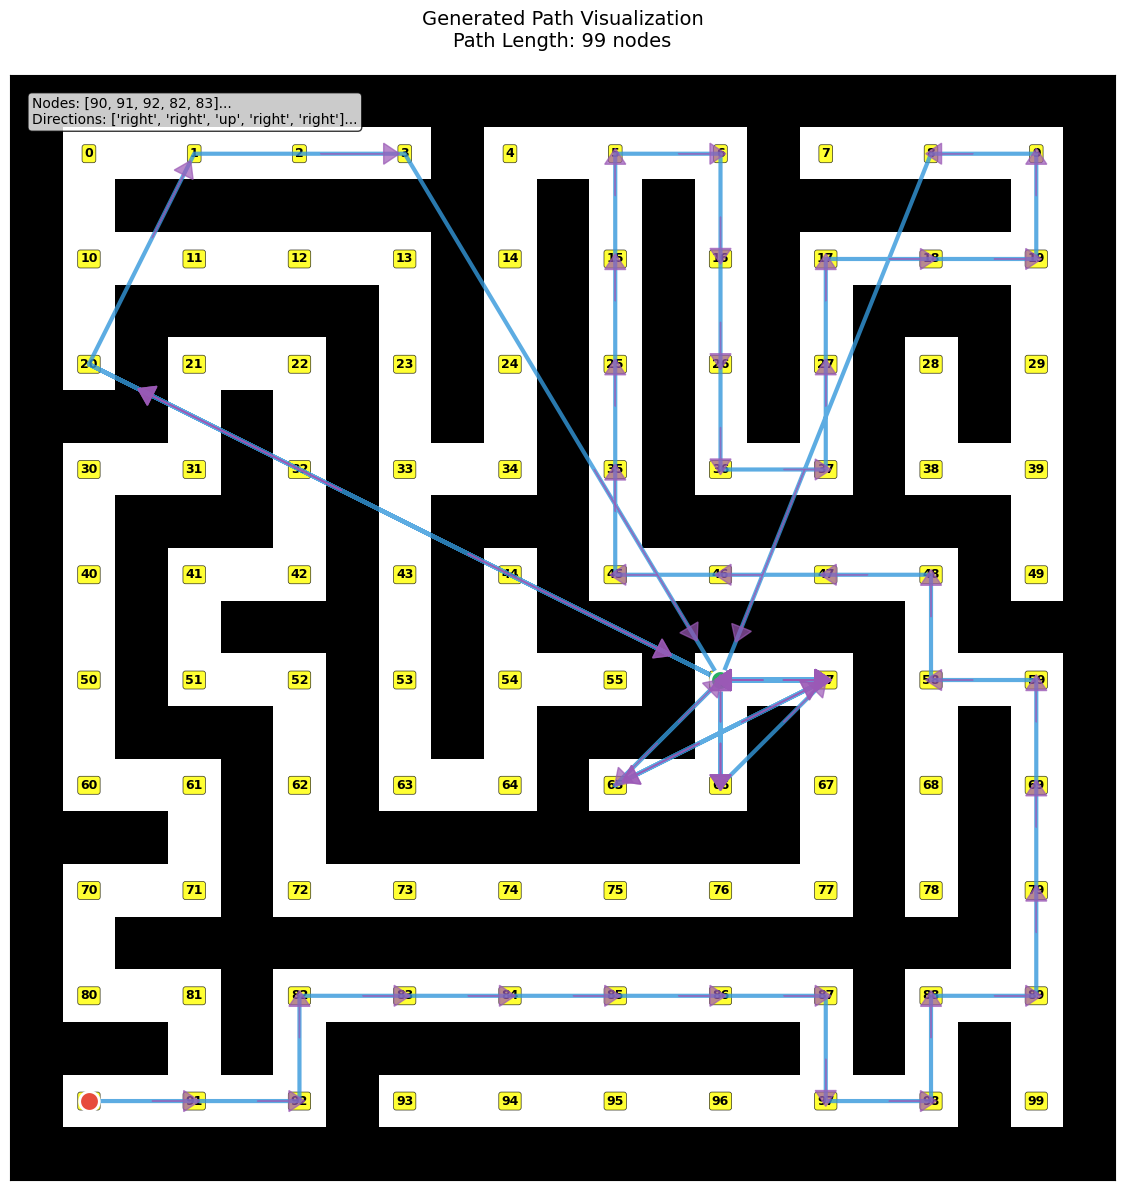

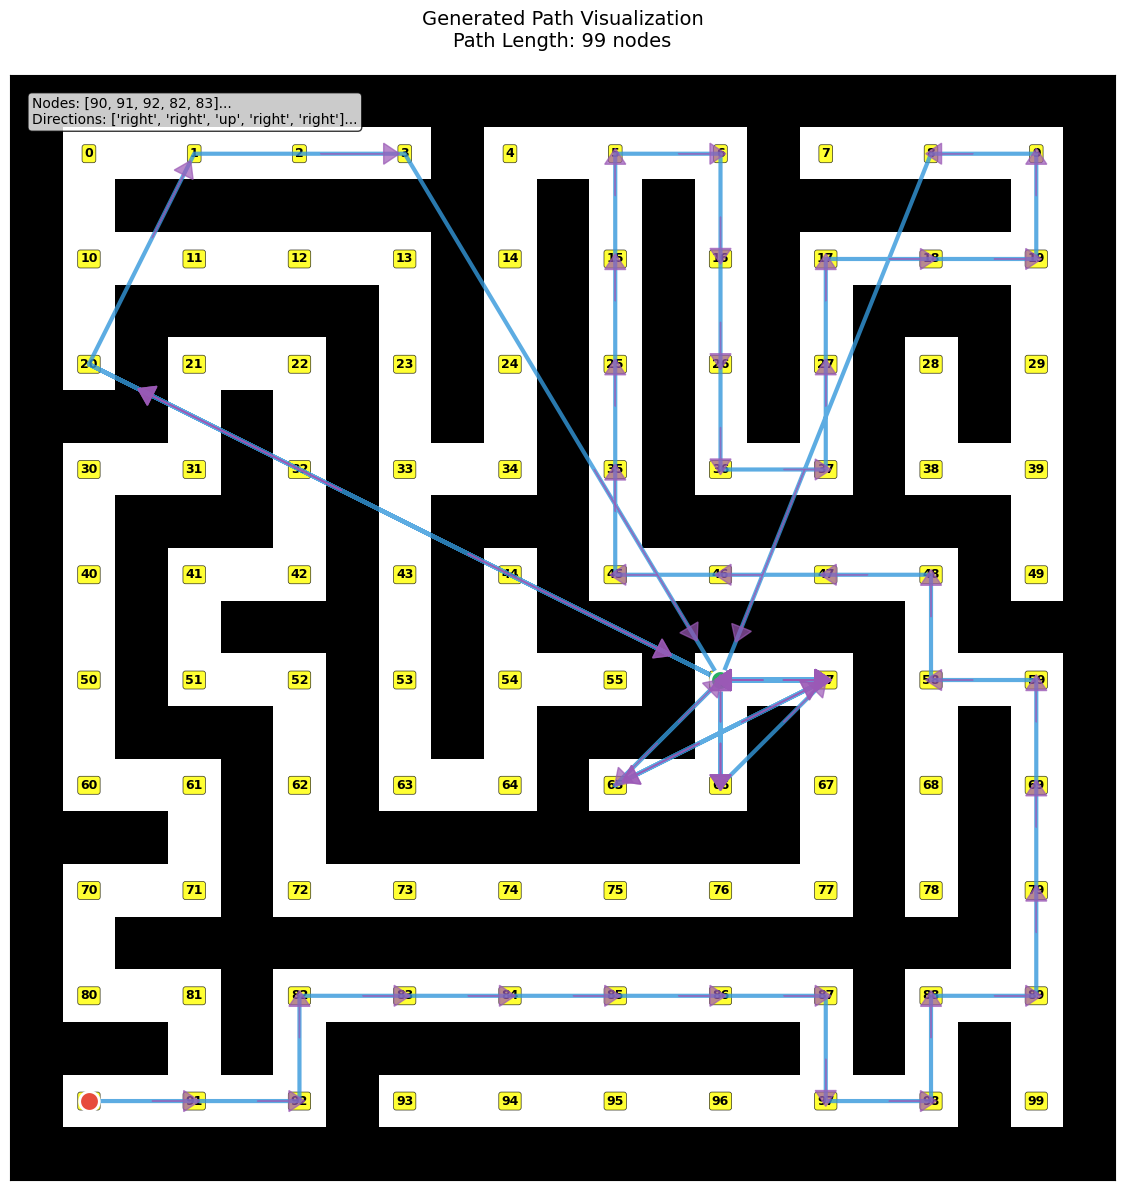

In [19]:
start = "90 93 90"
start_ids = tokenizer.encode(start)
print(start_ids)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
y = model.generate(x, max_length=200, temperature=1, top_k=1)
print(y)
visualize_generated_path(tokenizer.decode(y[0].tolist()))

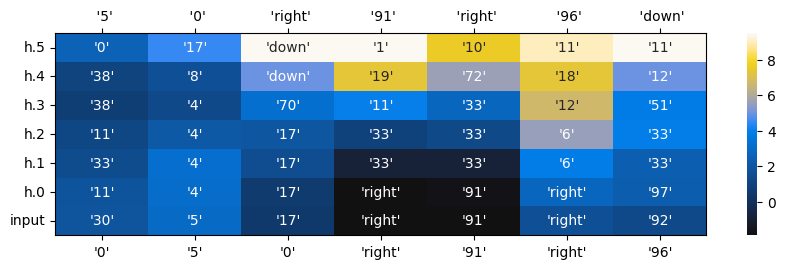

In [9]:
input_ids = tokenizer.encode("0 5 0").unsqueeze(0).to(device)
input_ids = torch.tensor([0, 5, 0, 101, 91, 101, 96, 102]).unsqueeze(0).to(device)
plot_logit_lens(model, tokenizer, input_ids, start_ix=0, end_ix=7)

In [10]:
import ecco

In [11]:
# Initialize ecco's LM with our fixed tokenizer
# The tokenizer can now handle both single tokens and lists properly
lm = ecco.LM(
    model=model,
    tokenizer=tokenizer,
    model_name='maze-gpt', # A custom name for our maze navigation model
    config={ # Config for ecco
        'model_name': 'maze-gpt',
        'type': 'causal',
        'embedding': 'transformer.wte', # Path to embedding layer in our model
        'activations': [".*mlp.c_fc"], # Regex to find MLP activation layers
        'tokenizer_config': {}
    },
    verbose=True, # Show generation process
    collect_activations_flag=True
)

# Test with a simple maze navigation input
input_text = "1 2 1"
input_ids = tokenizer.encode(input_text).unsqueeze(0)

print(f"Input text: {input_text}")
print(f"Input IDs: {input_ids}")

# Generate a few tokens
output = lm.generate(input_ids, generate=5, attribution=['ig', 'saliency'])

Input text: 1 2 1
Input IDs: tensor([[1, 2, 1]])


<IPython.core.display.Javascript object>

/home/xh/projects/grid-in-llm/model.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, device=self.device)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
output.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [13]:
output.layer_predictions(position=4, layer=3)

<IPython.core.display.Javascript object>

In [14]:
output.layer_predictions(position=3, layer=3) # TODO: check the indexing start with what

<IPython.core.display.Javascript object>

/home/xh/projects/grid-in-llm/open-source-library/ecco/src/ecco/output.py:469: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


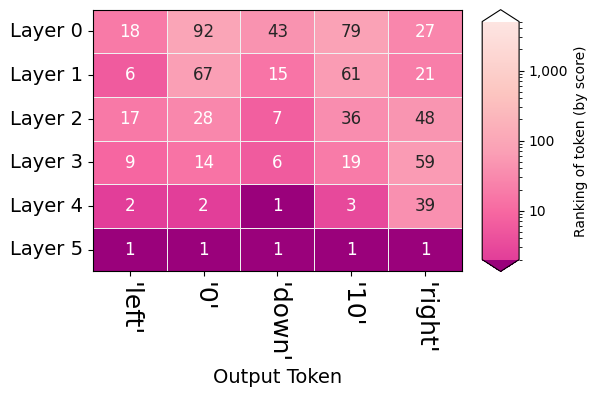

In [15]:
output.rankings()

In [16]:
input_ids = tokenizer.encode("1 2 1 up 4 down 5").unsqueeze(0)  
print(input_ids)
output = lm(input_ids)
nmf_output = output.run_nmf(n_components=8)
nmf_output.explore()

tensor([[  1,   2,   1, 100,   4, 102,   5]])


/home/xh/miniconda3/envs/general/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


<IPython.core.display.Javascript object>